# Probabilistic programming with PyMC

## Setup

To run this notebook, we need to set up a conda virtual environment with Python 3.6 (pymc doesn't work with Python 3.7), then install pymc, pydot and pydataset within it (we'll call the environment pymc):

```
conda update conda                         # Updates Anaconda
conda create -n pymc python=3.6 anaconda   # Creates a virtual environment called pymc with Python 3.6
conda activate pymc                        # Activates the pymc environment
conda install -n pymc pymc                 # Installs pymc in the pymc environment
conda install -n pymc pydot                # Installs pydot in the pymc environment
pip install pydataset                      # Installs pydataset in the currently activated environment
```

Every time we want to open this notebook, we should first activate the pymc virtual environment, then open the notebook (from the same terminal window).

We can exit the pymc virtual environment when we're done:

```
conda deactivate
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as mc
%matplotlib inline
import matplotlib as mpl
import scipy.stats
from pydataset import data

mpl.rcParams['figure.figsize'] = (6.0, 2.0)
mpl.rcParams['figure.dpi'] = 120

## Utility function to plot the graph of a PyMC model
def show_dag(model):
    dag = mc.graph.dag(model)
    dag.write("graph.png",format="png")
    from IPython.display import Image
    i = Image(filename='graph.png')
    return i

mpl.style.use('ggplot')
np.random.seed(2019)

# Neat things

* Demo of MCMC algorithms and their sampling properties: https://chi-feng.github.io/mcmc-demo/
* Hamiltoninan MCMC visually explained (great animations): http://arogozhnikov.github.io/2016/12/19/markov_chain_monte_carlo.html
* [A Conceptual Introduction to Hamiltonian Monte Carlo](https://arxiv.org/abs/1701.02434) An excellent paper on the theory of Hamiltonian Monte Carlo sampling
* [Introduction to MCMC](http://www.inference.org.uk/mackay/erice.pdf) by David Mackay

# Topic purpose
We will cover probabilistic **inference**. Rather than learning a single set of parameters by optimisation, we can model probability distributions over possible models that might be compatible with our data.  We'll use Monte Carlo sampling to make it simple and easy (if not very efficient) to work with probabilistic models. 


MCMC models:

* **Data**, which we observe as a collection of examples.
* A **model** which has **structure** (a DAG) and **parameters**
* Part of the model is a likelihood function which has "contact" with data; these we will call **observed random variables**
* Part of the model specifies distributions over parameters of the **observed variables**. These are **unobserved random variables**


## PyMC
<a id="pymc"> </a>
We'll use the excellent PyMC module to do the inference. If you have questions about this module, you can read [this tutorial](http://arxiv.org/abs/1507.08050) or the [API docs](https://pymc-devs.github.io/pymc/). 

# Fitting a normal distribution
## Bayesian Normal fitting
We use Monte Carlo sampling to estimate the mean and standard deviation of some data.

We assume we have data generated by a random process where $x \sim \mathcal{N}(\mu, \sigma^2)$, but we don't know $\mu$ or $\sigma$. We can place priors on $\mu$ and $\sigma$ and try and infer a distribution of plausible values.


### Test data
We generate some synthetic data from a known normal distribution. In this case we **know** that our data is in fact normally distributed, so our model assumptions are guaranteed to be correct. This isn't the typical case!!

$$x \sim \mathcal{N}(-1, 1.5)$$


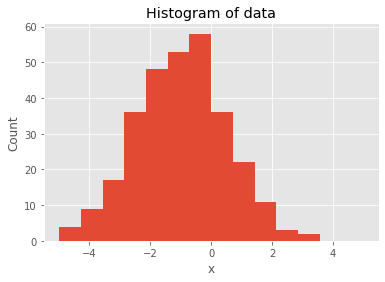

In [2]:
## generate data with a known distribution
## this will be our "observed" data

n_samples = 300

x_data = np.random.normal(-1, 1.5, (n_samples,))

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(x_data, bins=np.linspace(-5,5,15))
ax.set_title("Histogram of data")
ax.set_xlabel("x")
ax.set_ylabel("Count");

We then create a model in PyMC. We have a single output variable `x`, which is **stochastic** and **observed**, and the data we have observed is `x_data`. As it is observed, we will use the likelihood of the data under different model settings to accept/reject samples in the process. 

We use $\tau$ to represent the *reciprocal of variance*, as this is the standard model that PyMC uses. It makes it slightly easier to parameterise in some cases.

We have a model:

$$
\mu \sim \mathcal{N}(0, 10^2)\\
\tau \sim \mathcal{\Gamma}(2.0, 20.0)\\
x\sim\mathcal{N}(\mu, \frac{1}{\tau})\\
$$

In [3]:
# latent variables
mu = mc.Normal('mu', mu=0, tau=1.0/(10*10))  # wide range for prior on means
prec = mc.Gamma('prec', alpha=5.0, beta=20)  # wide range for prior on precision

/anaconda3/envs/pymc/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


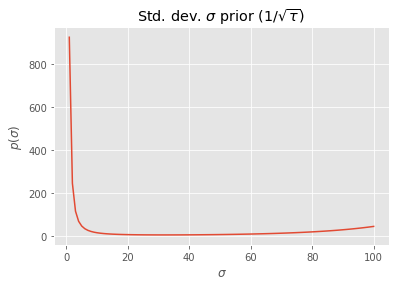

In [4]:
import scipy.stats

# plot the PDF of our prior
xs = np.linspace(0, 100, 100)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
# alpha = 1.0, beta = 20.0
ax.plot(xs, np.sqrt(1.0/scipy.stats.gamma(a=5.0, scale=8).pdf(xs)))

ax.set_xlabel("$\\sigma$")
ax.set_ylabel("$p(\\sigma)$")
ax.set_title("Std. dev. $\\sigma$ prior ($1/\sqrt{\\tau}$)");

In [5]:
# observed variable
observed_stochastic = mc.Normal('observed', 
                                 mu=mu, tau=prec, 
                                 observed=True, 
                                 value=x_data)

# if we want to sample from unconditioned prior
#observed_stochastic = mc.Normal('observed', mu=mu, tau=prec)

We have to set parents for every node. In this case, we have two parameters, $\mu$ and $\tau = \frac{1}{\sigma^2}$ to specify ($\tau$ is used to make it easier to parameterise priors over normals). We want to infer those, so we also make those stochastic variables, but unobserved (hidden). We specify the type of the distribution (here, `Normal` and `Uniform`) and we must then specify *those* parents. In this case, these are just concrete numbers (but we could go further if we wanted).


We also add a "false" variable that will be used to make draws from the predictive posterior. It is a variable with the same parents as the observed posterior, but unobserved. Here we generate 20 posterior predictive samples for every accepted MCMC sample.

We add a second "false" variable, that just transforms $\tau$ back into $\sigma$. The only purpose of doing this is so that PyMC captures samples in the right form and stores them in the trace object; we could just compute this after the fact.

In [6]:
# generate samples with same distribution
# here, we draw 20 samples in each sample
pred_posterior = mc.Normal('predictive', 
                           mu=mu, 
                           tau=prec, 
                           size=20)


# note: Lambda defines a deterministic transformation of its parents
# and the lambda expression must specify the parent variable as a 
# default parameter (prec=prec) to make the model compile
# (we'll see this as a triangular variable in the DAG, as it is not random)
std_dev = mc.Lambda('std_dev', lambda prec=prec: np.sqrt(1.0/prec))

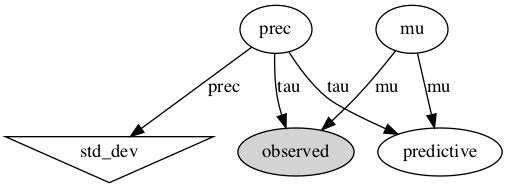

In [7]:
# display the graphical model
model = mc.Model([mu, prec, std_dev, observed_stochastic, 
                  pred_posterior])
show_dag(model)

We compile the model and show the graph. We can now draw samples from it, discarding the first portion:

In [8]:
# sample from the distribution
mcmc = mc.MCMC(model)

# throw away first 5000 samples (burn=5000)
mcmc.sample(iter=50000, burn=5000)

/anaconda3/envs/pymc/lib/python3.6/site-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 50000 of 50000 complete in 5.1 sec

The **trace** is the collection of posterior samples, as a straightforward array. We can plot these using the built in visualisation tool:


Plotting mu
Plotting prec
Plotting std_dev


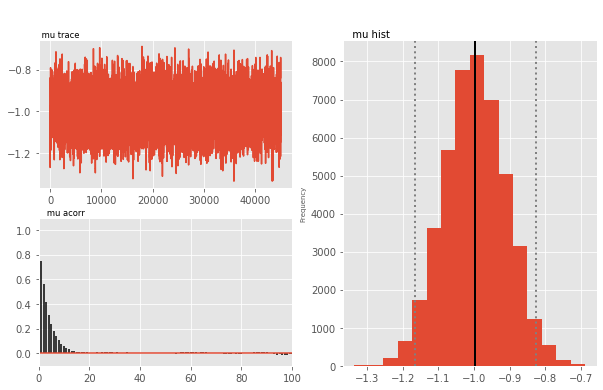

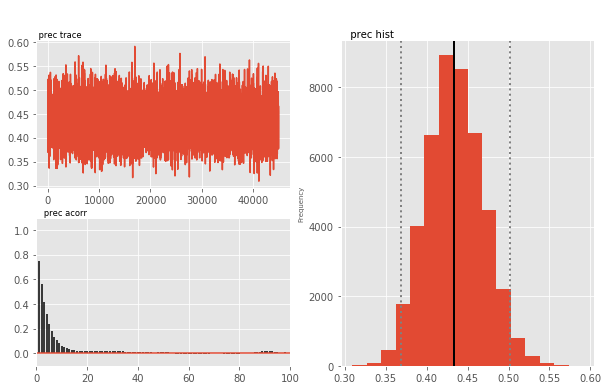

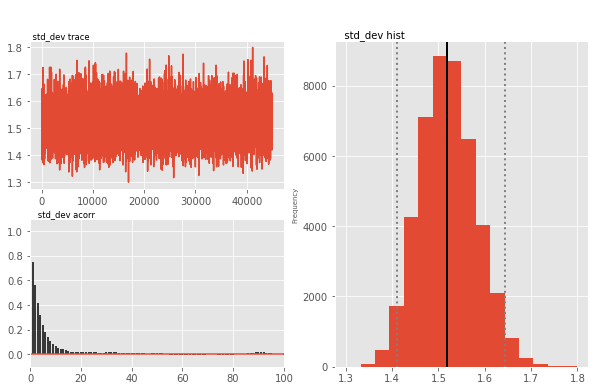

In [9]:
# standard trace plot
mc.Matplot.plot(mcmc)

We can also access them directly as arrays and plot them more flexibly (including showing draws from the predictive posterior):

In [10]:
def trace_hist(trace, name):
        n, bins, patches = plt.hist(trace, normed=True, bins=50)                
        max_n = np.max(n)
        plt.title("Estimate of {var_name}".format(var_name=name))
        
        # draw simple statistics
        ctr_max = 0.5 * (bins[np.argmax(n)] + bins[np.argmax(n)+1])
        plt.axvline(ctr_max, ls='-', color='r', lw=2, label='MAP')
        plt.axvline(np.median(trace), ls='-', color='C1', lw=2, label='Median')
        plt.axvline(np.mean(trace), ls=':', color='k', label='Expected')
        # 90% credible interval
        plt.axvline(np.percentile(trace, 5.0), ls=':', color='C1')
        plt.axvline(np.percentile(trace, 95.0), ls=':', color='C1')
        plt.fill_between(x=[np.percentile(trace, 5.0), np.percentile(trace, 95.0)], y1=max_n,
                          color='C1', alpha=0.2, label='90% credible')
        plt.text(np.mean(trace), 0.5*max_n, 'Mean')
        plt.legend()
        plt.gca().set_frame_on(False)
        
def show_trace(mcmc, vars_):
    ## plot histograms of possible parameter values
    # from the trace
    for var,name in vars_.items():
        fig = plt.figure()
        fig.set_facecolor("white")
        
        trace = mcmc.trace(var)[:].ravel()
        trace_hist(trace, name)
        
        
def correlate_trace(mcmc, var_a, var_b):
    # plot the correlation between two variables
    # in the posterior as a scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.scatter(mcmc.trace(var_a)[:], 
               mcmc.trace(var_b)[:], s=1, alpha=0.1)
    ax.set_aspect(1.0)
    ax.set_xlabel(var_a)
    ax.set_ylabel(var_b)
    

/anaconda3/envs/pymc/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


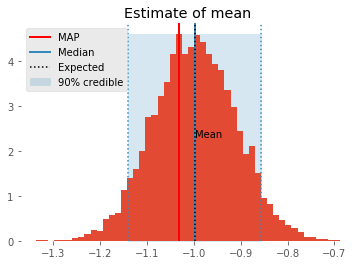

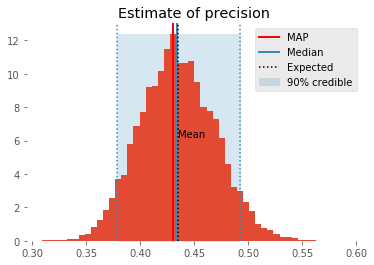

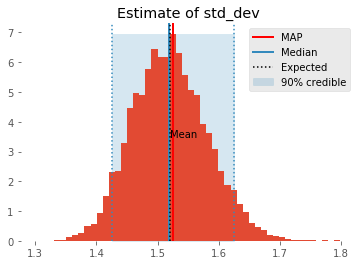

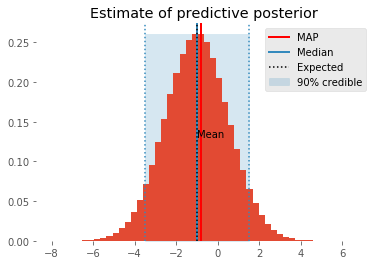

In [11]:
show_trace(mcmc, {"mu":"mean", 
                  "prec":"precision",
                  "std_dev":"std_dev",
                  "predictive":"predictive posterior"})

We can see if there are any correlations in the parameters (there probably shouldn't be very strong correlation in this case, though we'd expect the estimated `std_dev` to be higher when the `mean` is further from the true mean).

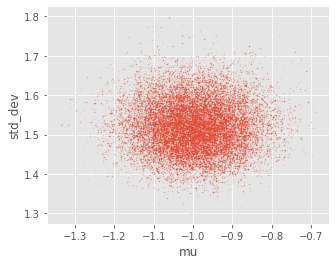

In [12]:
correlate_trace(mcmc, "mu", "std_dev")

## Changes to try:

* Show prior predictive (remove `observed=`)
* Show fixing \mu and \tau to known values
* Adjust $n$ to show effect of prior/posterior



# Transformations of variables


Fitting a uniform distribution instead, but using transformed variables. We parameterise in terms of centre and width of a uniform distribution, but transform these variables to the (lower, upper) form that the `Uniform` expects. This is a very simple example of transformations for inference.

$$
c \sim \mathcal{N}(0,10^2)\\
w \sim \mathcal{\Gamma}(2.0, 200)\\
l = c-w\\
u = c+w\\
x \sim \mathcal{U}(l,u)
$$


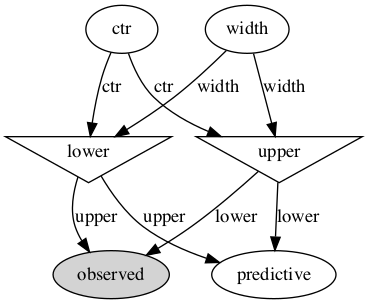

In [13]:
# latent variables
x_data = np.random.uniform(-2, 3, size=80)

np.random.seed(21225)
# Note: I *force* a good starting point (i.e. non-zero probability)
# otherwise PyMC will not be able to form the model
# this is why value=0 and value=100 are used

ctr = mc.Normal('ctr', mu=0, tau=1e-2, 
                )  # wide range for prior on means
width = mc.Gamma('width', alpha=2.0, 
                 beta=200.0, value=100.0)         # wide range for prior on precision



# uniform variable, in a unknown range
# note use of Lambda to transform parameters
lower = mc.Lambda('upper', lambda ctr=ctr, 
                  width=width: ctr-width)
upper = mc.Lambda('lower', lambda ctr=ctr, 
                  width=width: ctr+width)

observed_stochastic = mc.Uniform('observed', 
                                 upper=upper, 
                                 lower=lower, 
                                 observed=True, 
                                 value=x_data)

pred_posterior = mc.Uniform('predictive', 
                            upper=upper, 
                            lower=lower)

# display the graphical model
model = mc.Model([ctr, width, 
                  observed_stochastic, 
                  pred_posterior, upper, lower])
show_dag(model)

In [14]:
mcmc = mc.MCMC(model)
mcmc.sample(iter=50000, burn=1000, thin=8)

/anaconda3/envs/pymc/lib/python3.6/site-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 50000 of 50000 complete in 4.9 sec

/anaconda3/envs/pymc/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


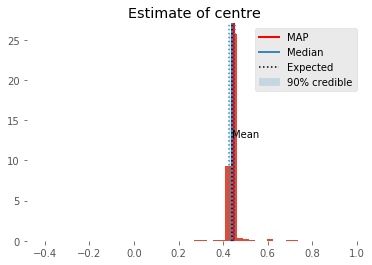

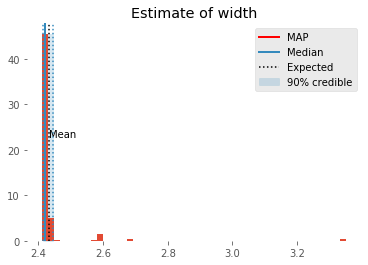

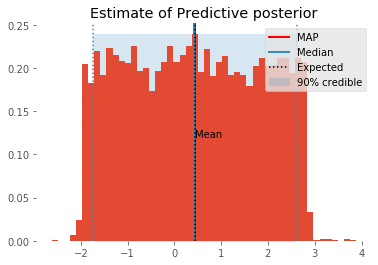

In [15]:
show_trace(mcmc, {"ctr":"centre", 
                  "width":"width", 
                  "predictive":"Predictive posterior"})

Plotting lower
Plotting ctr
Plotting width
Plotting predictive
Plotting upper


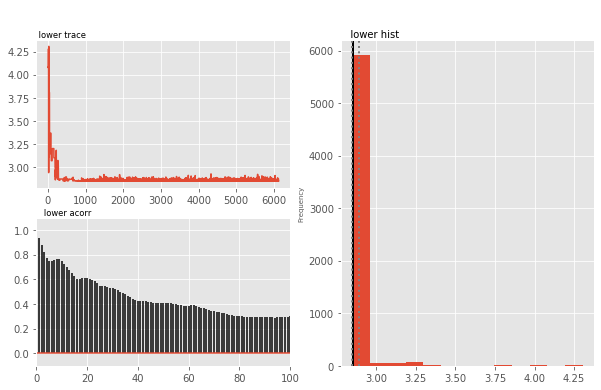

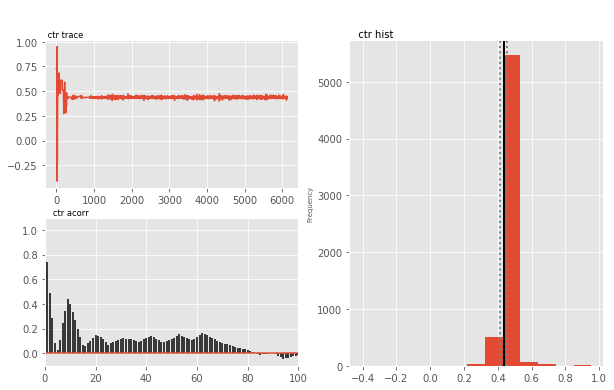

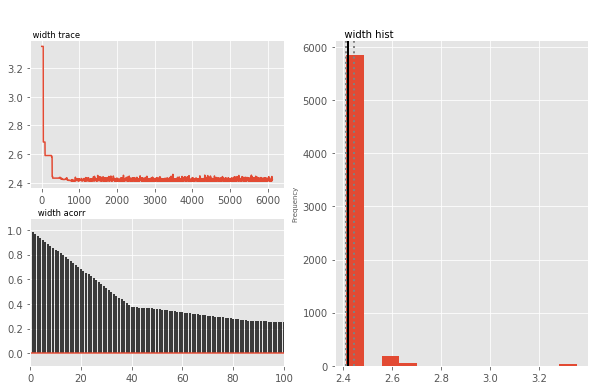

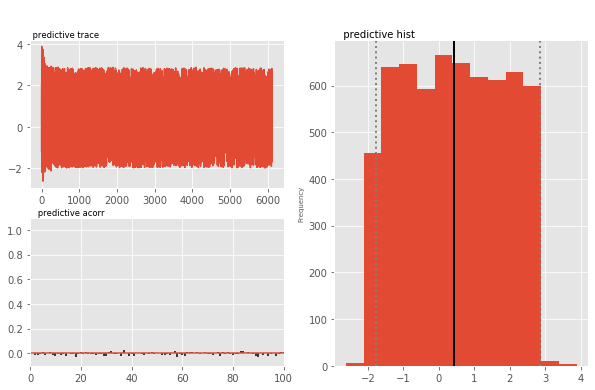

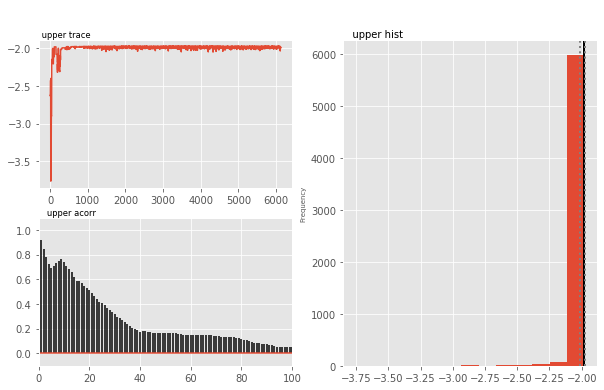

In [16]:
mc.Matplot.plot(mcmc)

---
# Linear regression

## Graphical models
<a id="graphical"> </a>

Transformations of expressions to graphs is familiar to most computer scientists -- it is an essential part of most optimising compilers. For example, the equation of a straight line might be written as a graph (this is how a compiler would break down the expression):

<img src="imgs/ymxc.png" width="300px">

## Adding unknowns
If we have multiple dependent random variables whose distribution we want to infer, we can draw a graph of dependencies to form a *graphical model*.  This explictly models dependencies between **random variables** (i.e. ones we don't know the value of precisely) and inference can be performed on the entire graph. 

**In CS terms, we are writing expressions down without fixing the variables, and then allowing the distribution of the values to be inferred when we observe data.** This inference process narrows down the likely range a random variable could take on (hopefully!).

In a **probabilistic graphical model**, some nodes in the graph are **observed** -- that is we know their state because we have explicity measured it, and others are **unobserved** -- we know (or have guessed) the form of their distribution but not the parameters of that distribution. Some dependencies are deterministic (i.e. fully defined by the values of their parents), while others are stochastic. We can infer the **posterior** distribution of unobserved nodes by integrating over the possible values that could have occured given the observed values.

We can modify our straight line equation to write a model for **linear regression**:

<img src="imgs/ymxc_stochastic.png">

All we need to do is specify that we expected the output $y$ to be normally distributed around the equation of a line given by $m$ and $c$; we can now **infer** $\sigma, m, c$ from observed data. Or we can fix any of them, and infer the remainder (if, e.g. we knew in advance that $c=0$). Our assumption here is that we will observe data which has a **latent structure** modelled by a linear dependence on a variable $x$, plus some normally-distributed observation noise.

**Note that we must put *some* prior distribution on every stochastic node and we can only observe stochastic nodes.**

----


Let's implement the linear regression model in the intro in practice, using PyMC to build a graphical model and then run MCMC to sample from the posterior (i.e. estimate the distribution of random variables after seeing some evidence).

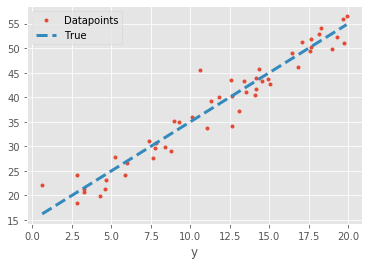

In [18]:
### Bayesian Linear Regression with pymc
### We use Monte Carlo sampling to estimate the distribution of a linear function with a normally
### distributed error, given some observed data.
### Vaguely based on: http://matpalm.com/blog/2012/12/27/dead_simple_pymc/ and http://sabermetricinsights.blogspot.co.uk/2014/05/bayesian-linear-regression-with-pymc.html


## generate data with a known distribution
## this will be our "observed" data
x = np.sort(np.random.uniform(0,20, (50,)))
m = 2
c = 15

# Add on some measurement noise, with std. dev. 3.0
epsilon = data = np.random.normal(0, 3, x.shape)
y = m * x + c + epsilon

plt.plot(x,y, '.', label="Datapoints")
plt.plot(x, m*x+c, '--', lw=3, label="True")
plt.legend()
plt.xlabel("x")
plt.xlabel("y");

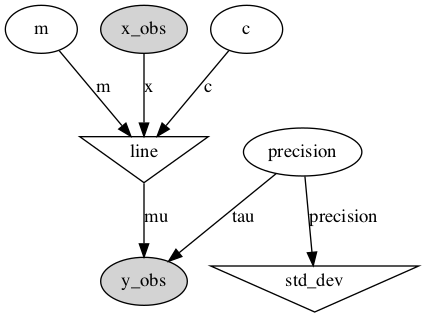

In [19]:
## Now, set up the PyMC model

## specify the prior distribution of the unknown line function variables
## Here, we assume a normal distribution over m and c
m_unknown = mc.Normal('m', 0, 0.01)
c_unknown = mc.Normal('c', 0, 0.001)

## specify a prior over the precision (inverse variance) of the error term
# precision = 1/variance
## Here we specify a uniform distribution from 0.001 to 10.0
precision = mc.Uniform('precision', 
                       lower=0.001, 
                       upper=10.0)

# this is just a convenience for plotting
std_dev = mc.Lambda("std_dev", 
                    lambda precision=precision: 
                    np.sqrt(1.0/precision))

# specify the observed input variable
# we use a normal distribution, but this has no effect --
# the values are fixed and the parameters
# never updated; this is just a way of transforming x 
# into a variable pymc can work with
# (it's really a hack)
x_obs = mc.Normal("x_obs", 0, 1,
                  value=x, observed=True)

@mc.deterministic(plot=False)
def line(m=m_unknown, c=c_unknown, x=x_obs):
    return x*m+c

# specify the observed output variable 
y_obs =  mc.Normal('y_obs', mu=line, 
                   tau=precision, 
                   value=y, 
                   observed=True
                  )

model = mc.Model([m_unknown, c_unknown, precision, x_obs, y_obs, std_dev])

# display the graphical model
show_dag(model)

In [20]:
# sample from the distribution
mcmc = mc.MCMC(model)
mcmc.sample(iter=50000, burn=1000, thin=1)

/anaconda3/envs/pymc/lib/python3.6/site-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 50000 of 50000 complete in 5.3 sec

/anaconda3/envs/pymc/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


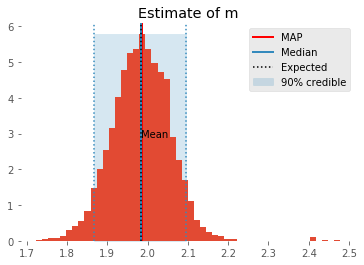

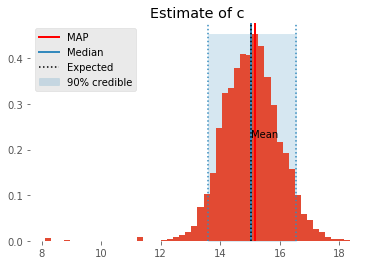

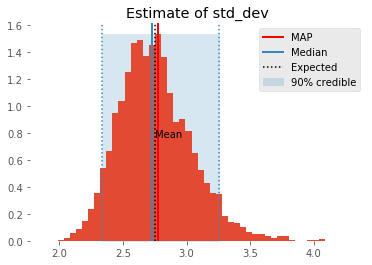

In [21]:
show_trace(mcmc, {"m":"m", 
                  "c":"c", 
                  "std_dev":"std_dev"})

## Draws from the posterior predictive model


[<img src="https://imgs.xkcd.com/comics/error_bars.png">](https://xkcd.com/2110)



(-40, 80)

/anaconda3/envs/pymc/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/anaconda3/envs/pymc/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


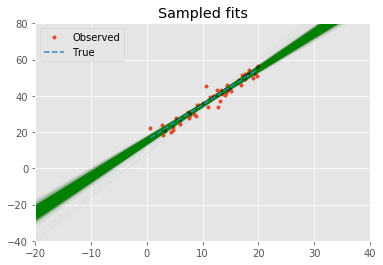

In [22]:
## now plot overlaid samples from the linear function
## Note: this *ignores* the error distribution we've estimated
## If we drew samples from the true posterior predictive, 
# we'd see much greater spread
## in possible simulations
ms = mcmc.trace("m")[:]
cs = mcmc.trace("c")[:]

plt.title("Sampled fits")
plt.plot(x, y, '.', label="Observed")

xf = np.linspace(-20,40,200)
for m,c in zip(ms[::20], cs[::20]):    
    plt.plot(xf, xf*m+c, 'g-', alpha=0.01)
plt.plot(x, x*m+c, '--', label="True", zorder=100)
plt.legend()
plt.xlim(-20,40)
plt.ylim(-40,80);

## Simple diagnostics
Is our sampler taking uncorrelated samples? We can look at the **autocorrelation** of the samples. If they are perfectly unbiased, then this should be zero everywhere (no correlation between successive samples). We want to draw independent unbiased samples from the posterior, but an MCMC sampling process produces highly correlated samples (each sample depends on the previous). We want to measure and minimise that sample-to-sample correlation, which is captured by the autocorrelation.

Plotting std_dev
Plotting m
Plotting c
Plotting precision


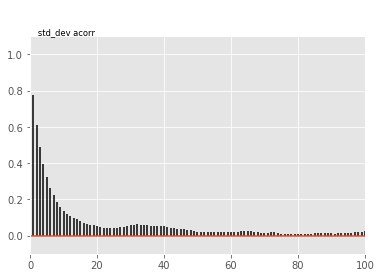

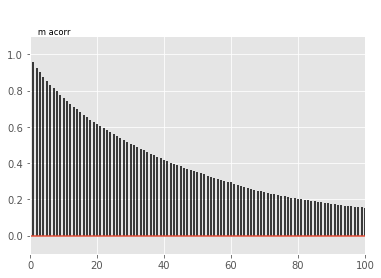

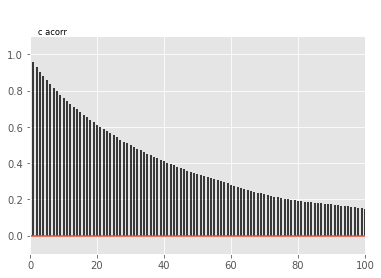

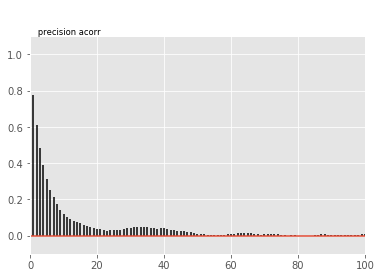

In [23]:
mc.Matplot.autocorrelation(mcmc)

## Basic convergence statistics
### Gelman-Rubin
Measures intra-chain versus inter-chain variance (should be similar if mixing is good). Measures close to 1.0 indicate good mixing.

In [24]:
# need to run chain multiple times to estimate the Gelman-Rubin
# metric; as it compares different runs for similarity of variance

for i in range(10):
    mcmc.sample(iter=50000, burn=1000, thin=1)

# closer to 1.0 is better (means within chain variance is close to across chain 
# variance)

mc.gelman_rubin(mcmc)

 [-----------------100%-----------------] 50000 of 50000 complete in 5.2 sec

{'std_dev': 1.0000500952329663,
 'm': 1.0008818314392156,
 'c': 1.0009027485417565,
 'precision': 1.0000659846129774}

### Rafferty-Lewis
Estimates the burn-in and thinning required. See below for an explanation of burn-in and thinning.

In [25]:
# this will print results for all 10 chains
mc.raftery_lewis(mcmc, q=0.025, r=0.01)


Raftery-Lewis Diagnostic

937 iterations required (assuming independence) to achieve 0.01 accuracy with 95 percent probability.

Thinning factor of 2 required to produce a first-order Markov chain.

18 iterations to be discarded at the beginning of the simulation (burn-in).

4972 subsequent iterations required.

Thinning factor of 8 required to produce an independence chain.

Raftery-Lewis Diagnostic

937 iterations required (assuming independence) to achieve 0.01 accuracy with 95 percent probability.

Thinning factor of 11 required to produce a first-order Markov chain.

66 iterations to be discarded at the beginning of the simulation (burn-in).

18238 subsequent iterations required.

Thinning factor of 26 required to produce an independence chain.

Raftery-Lewis Diagnostic

937 iterations required (assuming independence) to achieve 0.01 accuracy with 95 percent probability.

Thinning factor of 8 required to produce a first-order Markov chain.

56 iterations to be discarded at the be

{'std_dev': (937, 2, 18, 4972, 8),
 'm': (937, 11, 66, 18238, 26),
 'c': (937, 8, 56, 14232, 24),
 'precision': (937, 2, 18, 4954, 9)}



# Sampling issues
## Burn-in and thinning

 The **great thing** about MCMC approaches is that you can basically write down your model and then run inference directly. There is no need to derive complex approximations, or to restrict ourselves to limited models for which we can compute answers analytically. Essentially, no maths by hand; everything is done algorithmically.

The **bad thing** about MCMC approaches is that, even though it will do the "right thing" *asymptotically*, the choice of sampling strategy has a very large influence for the kind of sample runs that are practical to execute. Bayesian inference should depend only on the priors and the evidence observed; but MCMC approaches also depend on the sampling strategy used to approximate the posterior. 

### Dealing with biased sampling
MCMC tries to draw **independent, unbiased** samples from the posterior, but the sampling process (like Metropolis), is not inherently unbiased. For example, successive samples in a random walk are correlated and obviously not independent. 

And although the Markov Chain approach (under fairly relaxed assumptions) will asympotically sample from all of the posterior, if the random walk starts off very far from the bulk of the distribution, it will "wander in the wilderness" for some time before reaching significant probability density. This means early samples from the distribution might be unreasonably dense in very low probability regions in the posterior. How "good" the Markov chain is at sampling from the posterior is called **mixing**; some MCMC setups may mix very badly until they get warmed up.

To mitigate these two common issues, there are a couple of standard tricks: 
* **Burn-in**, which ignores the first $n$ samples from an MCMC draw, to make sure the chain is "mixing" well. Typically, several thousand samples might be ignored.
* **Thinnning**, which takes one sample from every $k$ consecutive samples from the chain, to reduce correlation. Values of raound 5-50 are common.

Tuning these is a matter of art!

The code below implements M-H sampling from the lecture notes, and then shows how burn-in and thinning can be applied.

In [26]:
def metropolis(fx, q, x_init ,n):
    # Perform Metropolis MCMC sampling.
    # p(x): a function that can be evaluated anywhere. p(x) returns the value of p at x
    # q(): a function q that draws a sample from a symmetric distribution and returns it
    # x: a starting point
    # n: number of samples
    
    x = np.array(x_init)
    samples = np.zeros((n, x.shape[0]))
    accepted = np.zeros(n)
    # precompute random numbers
    random_uniform = np.random.uniform(0,1,n)
        
    for i in range(n):
        # find a new candidate spot to jump to
        x_prime =  q(x)        
        p_r = fx(x_prime) / fx(x)
        r = random_uniform[i]
        samples[i] = x_prime        
        # if it's better, go right away
        if r<p_r:            
            x = x_prime
            accepted[i] = 1            
        else:
            accepted[i] = 0
                            
    return samples[accepted>0], samples[accepted<1]

In [27]:
import scipy.stats

# try adjusting the step size
# 0.75 mixes well
# 0.15 gets stuck in modes
# 0.01 nevers goes anywhere
# 5.0 is almost always rejected
proposal_step_size = 5.0

# test the sampling process
# create an interesting distribution p (just a mixture of two gaussians)
A = np.array([[0.15, 0.9], [-0.3, 2.5]])
p1 = lambda x:scipy.stats.multivariate_normal(mean=[0,0], cov=A).pdf(x)
p2 = lambda x:scipy.stats.multivariate_normal(mean=[3,0], cov=np.eye(2)).pdf(x)
p = lambda x:p1(x)*0.5+p2(x)*0.5
# create a proposal distribution, with std. dev. 0.5
q = lambda x: np.random.normal(x,proposal_step_size,(2,))

# make 500 MCMC steps, starting in  very bad point (to illustrate
# the utility of burn in)
accept, reject = metropolis(p,q,[10.5, 30], 5000)

Text(0.5, 1.0, 'MCMC sampling with Metropolis-Hastings')

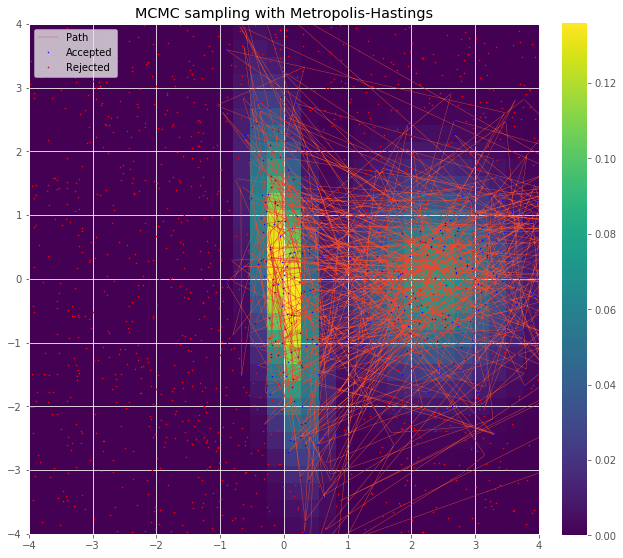

In [28]:
# plot a heatmap of the distribution, along with the
# accepted and rejected samples from that MCMC chain
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.plot(accept[:,0], accept[:,1], label="Path", lw=0.4)
ax.plot(accept[:,0], accept[:,1], 'b.', label='Accepted', markersize=1)
ax.plot(reject[:,0], reject[:,1], 'rx', label='Rejected', markersize=1)
ax.legend()
x,y = np.meshgrid(np.linspace(-5,5,30), np.linspace(-4,4,30))
img = ax.imshow(p(np.dstack([x,y])), extent=[-4,4,-4,4], cmap='viridis', origin='lower')
ax.grid("off")
fig.colorbar(img, ax=ax, fraction=0.046, pad=0.04)
ax.set_title("MCMC sampling with Metropolis-Hastings");       

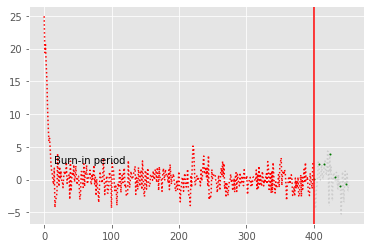

In [29]:
## Burn-in and thinning plot

# introduce correlations
y = accept[:,1] 
x = np.arange(len(y))

# discard 400 samples, keep every 8th sample
burn = 400
thin = 8
plt.plot(x[0:burn], y[0:burn], 'r:')
plt.plot(x[burn::thin], y[burn::thin], 'go', markersize=1)
plt.plot(x[burn:], y[burn:], 'k:', alpha=0.1, markersize=0.2)
plt.plot(x[burn:], y[burn:], 'k.', alpha=0.1, markersize=0.2)


plt.axvline(burn, c='r')
plt.text(15,2.5,"Burn-in period");

The red samples are discarded during burn-in, and the green samples (thinned to every 8th sample) are kept during the remainder of the sampling process. This helps to draw unbiased samples from the posterior.

[The PyMC manual](https://pymc-devs.github.io/pymc/modelchecking.html) explains a number of other diagnostic statistics and plots. **None of these are definitive**, but can give skilled MCMC practitioners insight into the operation of the sampling process.
If you're interested in leaning more about MCMC, David Mackay's [book chapter](http://www.inference.phy.cam.ac.uk/mackay/itprnn/ps/356.384.pdf) is a good reference.

----


# Logistic regression example: discrete dependent variable
On ye olde iris dataset, using the four flower measurements to predict whether or not
the species is `setosa` or another type of iris.

We estimate a set of coefficients $\beta_0, \beta_1, \dots$ and use the logistic function to transform the a linear model into a probability for a Bernoulli variable.

In [30]:
from pydataset import data
from sklearn.model_selection import train_test_split

iris = data("iris")
iris["is_setosa"] = np.where(iris["Species"]=="setosa", 1, 0)

In [31]:
iris.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species,is_setosa
1,5.1,3.5,1.4,0.2,setosa,1
2,4.9,3.0,1.4,0.2,setosa,1
3,4.7,3.2,1.3,0.2,setosa,1
4,4.6,3.1,1.5,0.2,setosa,1
5,5.0,3.6,1.4,0.2,setosa,1


In [32]:
# split the data into a train and test set
iris_train, iris_test = train_test_split(iris)
print("Train size", iris_train.shape)
print("Test size", iris_test.shape)

Train size (112, 6)
Test size (38, 6)


## Model:

We have some coefficients $\beta$, which feed into our logistic function to produce $l$, and $y$ is Bernoulli distributed (0 or 1) with probability $l$.

$$
\beta_i \sim \mathcal{N}(0, 5)\\
l = \frac{1}{1+e^{\beta_0 + \sum_i \beta_i x_i}}\\
y \sim \mathcal{B}(l)\\
$$

In [33]:
# binary prediction of "is_setosa", using the four attributes
# of the flower configuration

# predictors (standardised)
xs = np.array(iris_train.iloc[:, 0:4])
x_standardised = (xs - xs.mean()) / xs.std()

# observed values
ys = np.array(iris_train["is_setosa"])

# PyMC variable for inputs
x_std = mc.Normal("x_std", 0, 1, 
                  value=x_standardised, 
                  observed=True)

# 4 regression coefficients
betas = mc.Normal("betas", mu=0, tau=1.0/(50*50), 
                  size=5, value=[0,0,0,0,0])

# link function
@mc.deterministic
def logistic(betas=betas, x_std=x_std):
    return 1.0 / (1 + np.exp(-(betas[0] 
                               + np.sum(betas[1:] * x_std))))

# observed output is Bernoulli distributed
y = mc.Bernoulli("y", p=logistic, 
                 observed=True, value=ys)

model = mc.Model([x_std, y,betas, logistic])

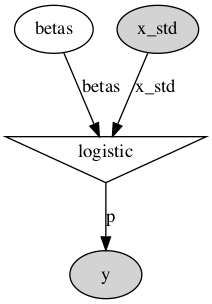

In [34]:
show_dag(model)

In [35]:
mcmc = mc.MCMC(model)

## Run the sampler with 5 different chains
mcmc.sample(iter=150000, burn=10000, thin=10)

/anaconda3/envs/pymc/lib/python3.6/site-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 150000 of 150000 complete in 9.7 sec

/anaconda3/envs/pymc/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


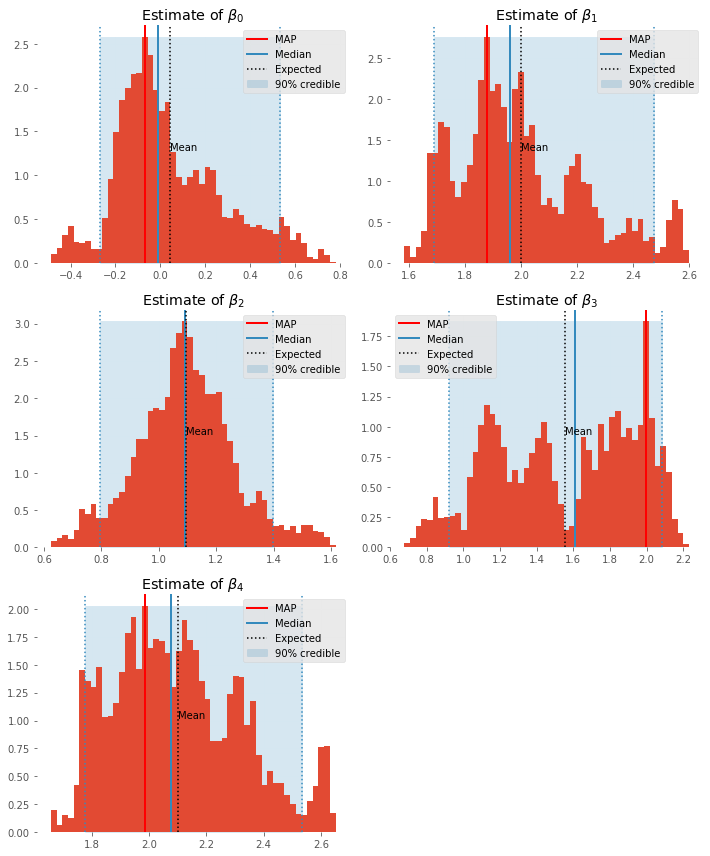

In [36]:
fig = plt.figure(figsize=(10,12))
for i in range(5):
    ax = fig.add_subplot(3,2,i+1)    
    trace_hist(mcmc.trace("betas")[:,i], "$\\beta_{i}$".format(i=i))
    
plt.tight_layout()

In [37]:
import sklearn.metrics

# write link function for use in prediction
def logistic_predict(betas, x_std):
    return 1.0 / (1 + np.exp(-(betas[0] + np.sum(betas[1:] * x_std, axis=1))))

# standardise predictors in test set
test_x = iris_test.iloc[:, 0:4]
test_x = (test_x - np.mean(test_x))/np.std(test_x)

y_true = iris_test["is_setosa"]

## Predictions
We can draw samples from the posterior and then use the regression coefficients to make new predictions. Annoyingly, 
we have to rewrite the logistic function, but this is easy to do.

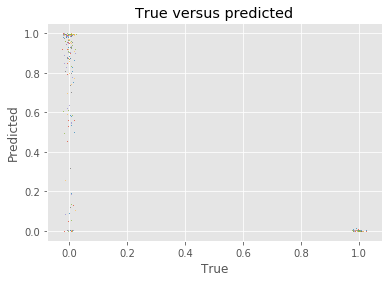

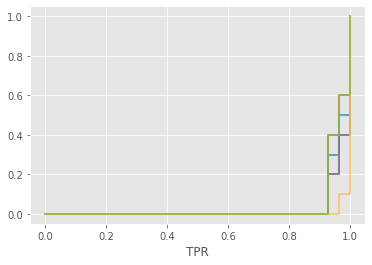

In [38]:
# plot for true versus predicted
fig1 = plt.figure()
ax1 = fig1.add_subplot(1,1,1)
ax1.set_xlabel("True")
ax1.set_ylabel("Predicted")
ax1.set_title("True versus predicted")

# plot for ROC curve
fig2 = plt.figure()
ax2 = fig2.add_subplot(1,1,1)
ax2.set_xlabel("FPR")
ax2.set_xlabel("TPR")

confusions = []
beta_trace = mcmc.trace("betas")[:]

# predict 
for i in range(6):
    # choose a random set of betas
    beta_ix = np.random.randint(0, beta_trace.shape[0]-1)
    beta_vec = beta_trace[beta_ix, :]        
    y_pred =  logistic_predict(beta_vec, test_x)    
    ax1.scatter(y_true+np.random.normal(0,0.01,
                                        y_true.shape),
                y_pred,s=0.2)
    # bias is due to unbalanced classes (I think)
    y_class = np.where(y_pred<0.5, 0, 1)
    confusion = sklearn.metrics.confusion_matrix(y_true, y_class)    
    confusions.append(confusion)
        
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true, y_pred)
    ax2.plot(fpr, tpr)
        

## Distribution of confusion matrices
We can show the (samples from) distribution of confusion matrices if we want:

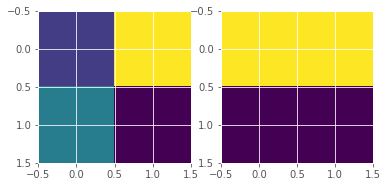

In [39]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(np.mean(confusions, axis=0))
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(np.std(confusions, axis=0));

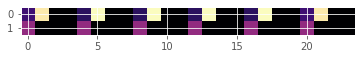

In [40]:
# show samples from the confusion matrices
confusions = np.array(confusions)
# some tensor reshaping fun...
confusion_pad = np.stack([confusions, np.zeros_like(confusions)]).swapaxes(0,1)
flat = np.concatenate(np.concatenate(confusion_pad, axis=0), axis=1)
plt.imshow(flat, cmap='magma');

----

# Switchpoint model: more complex logic

<img src="poverty_rates.png">

*[Source: https://ourworldindata.org/extreme-history-methods]*

Data not provided, so hand-digitised via https://apps.automeris.io/wpd/



In [41]:
import pandas as pd
from io import StringIO

# load data from a string

data = StringIO("""year,poverty_rate
1819.8097502972653, 83.88791593695271
1849.6789536266351, 81.646234676007
1869.655172413793, 75.48161120840629
1889.821640903686, 71.6987740805604
1909.6076099881093, 65.67425569176883
1928.8228299643283, 56.42732049036777
1949.7502972651605, 54.8861646234676
1959.6432818073722, 44.09807355516638
1969.7265160523186, 35.69176882661996
1979.8097502972653, 31.62872154115587
1991.6052318668253, 23.782837127845866
2004.922711058264, 13.695271453590195
2001.8787158145064, 17.19789842381782
1999.0249702734839, 19.159369527145344
1995.9809750297266, 19.299474605954472
1987.0392390011891, 24.483362521891436
1989.8929845422117, 24.483362521891436
1983.9952437574316, 27.98598949211906
1980.9512485136743, 33.450087565674266
1992.936979785969, 22.521891418563897""")

poverty_ = pd.read_csv(data)
# deleting the dodgy data point
# uncomment to experiment
# poverty = poverty_.drop(labels=[6])

poverty = poverty_
poverty

,year,poverty_rate
0,1819.809750,83.887916
1,1849.678954,81.646235
2,1869.655172,75.481611
3,1889.821641,71.698774
4,1909.607610,65.674256
5,1928.822830,56.427320
6,1949.750297,54.886165
7,1959.643282,44.098074
8,1969.726516,35.691769
9,1979.809750,31.628722


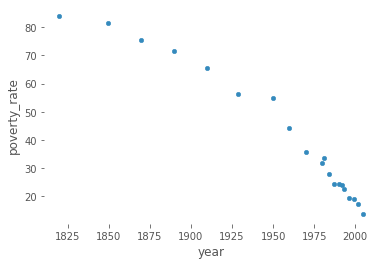

In [42]:
poverty.plot(x='year', y='poverty_rate', kind='scatter')
plt.gca().set_frame_on(False)

### Hypothesis
We model the data with a linear regression, but where there is a switchpoint, where the regression coefficient changes (i.e. piecewise linear with two pieces). We estimate both the regression coefficients at each position and the location of the switchpoint.

$$s \sim \mathcal{N}{(1960, 100)}\\
\beta_0 \sim \mathcal{N}(50, 10)\\
\beta_1 \sim \mathcal{N}(-1, 2)\\
\beta_2 \sim \mathcal{N}(-1, 2)\\
$$

$$
\mu = \begin{cases}
x<s & \beta_0 + \beta_1 (x-s)\\
x>s & \beta_0 + \beta_2 (x-s)\\
\end{cases}
$$


$$
\tau \sim \mathcal{\Gamma}(1, 10) \\
y \sim \mathcal{N}(\mu, \frac{1}{\tau})
$$


In [43]:
# PyMC variable for inputs
x = mc.Normal("x", mu=0, tau=1, 
              observed=True, value=poverty["year"])

# 3 betas
beta_0 = mc.Normal("beta_0", mu=50, tau=1.0/(10.0))

beta_1 = mc.Normal("beta_1", mu=-1, tau=1.0/(2*2))
beta_2 = mc.Normal("beta_2", mu=-1, tau=1.0/(2*2))

precision = mc.Gamma("precision", alpha=0.5, beta=1)
# alternatively, could postulate uniform
#switch = mc.Uniform("switch", lower=1820, upper=2020)
switch = mc.Normal("switch", mu=1935, 
                   tau=1.0/(50.0*50.0))

# link function
@mc.deterministic
def switch_mu(beta_0=beta_0, beta_1=beta_1, 
              beta_2=beta_2,
              x=x, switch=switch):
    
    return np.where(x<switch, 
                    beta_0 + beta_1 * (x-switch),
                    beta_0 + beta_2 * (x-switch))

std = mc.Lambda("std_dev", 
                lambda precision=precision:np.sqrt(1.0/precision))

y = mc.Normal("y", mu=switch_mu, tau=precision, 
              observed=True, 
              value=poverty["poverty_rate"])

model = mc.Model([x, y, precision, beta_0, 
                  beta_1, beta_2, switch, switch_mu, std])

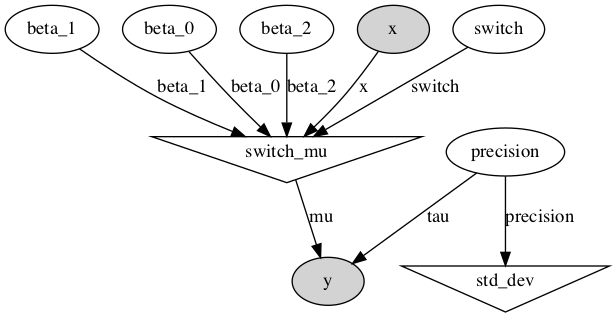

In [44]:
show_dag(model)

In [45]:
mcmc = mc.MCMC(model)
mcmc.sample(iter=200000, burn=2000, thin=20)

/anaconda3/envs/pymc/lib/python3.6/site-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 200000 of 200000 complete in 33.8 sec

/anaconda3/envs/pymc/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


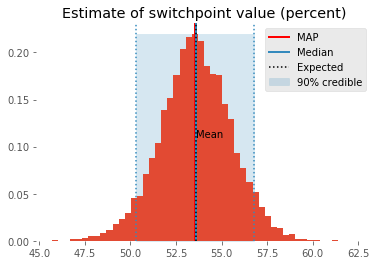

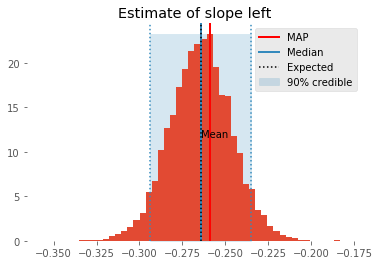

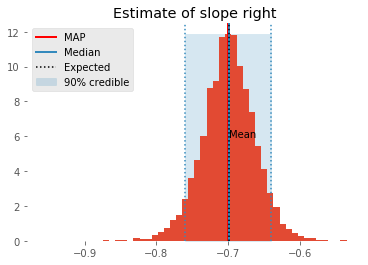

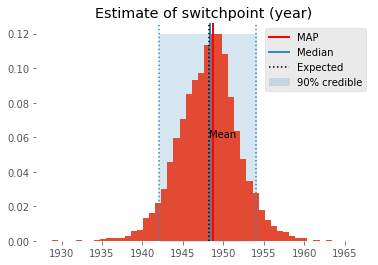

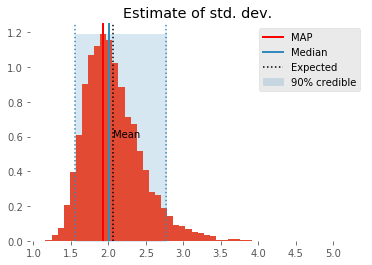

In [46]:
show_trace(mcmc, {"beta_0":"switchpoint value (percent)", 
                  "beta_1":"slope left",
                  "beta_2":"slope right",
                  "switch":"switchpoint (year)",
                 "std_dev":"std. dev."})

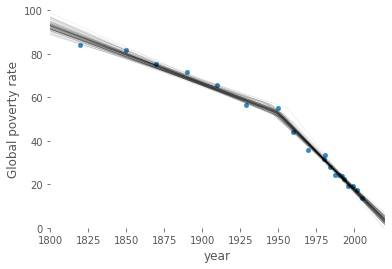

In [47]:
poverty.plot(x='year', y='poverty_rate', kind='scatter')
ax = plt.gca()
ax.set_frame_on(False)
ax.set_ylabel("Global poverty rate")
ax.set_xlim(1800,2020)
ax.set_ylim(0,100)
plt.gcf().set_facecolor('white')

beta_0_trace = mcmc.trace("beta_0")[:]
beta_1_trace = mcmc.trace("beta_1")[:]
beta_2_trace = mcmc.trace("beta_2")[:]
switch_trace = mcmc.trace("switch")[:]
tau_trace = mcmc.trace("precision")[:]


for i in range(100):
    ix = np.random.randint(0, beta_0_trace.shape[0]-1)
    s = switch_trace[ix]    
    
    tau = tau_trace[ix]
    x1 = np.clip(s-200, 1800, 2020)
    x2 = s
    x3 = np.clip(s+200, 1800, 2020)
    y1 = beta_0_trace[ix] + beta_1_trace[ix] * (x1-s)
    y2 = beta_0_trace[ix] + beta_1_trace[ix] * (x2-s)
    y3 = beta_0_trace[ix] + beta_2_trace[ix] * (x3-s)
    ax.plot([x1,x2,x3], [y1,y2,y3], 'k', lw=0.05);

----

# A simple mixture model: discrete + continuous latent variables
## When things get tricky

We can include both **discrete** and **continuous** variables. A very important case is where we have a **mixture model**. That is, we believe our observations come from one of a number of distributions. For example, in modelling human heights, we might expect height to be normally distributed, but to have two different distributions for men and women.

<img src="imgs/mixture.png">

It is very straightforward to add this to a PyMC graphical model; it is just another random variable to infer. However, sampling is another matter.

In this case we do full **clustering**.  That is, we suppose the data is generated by three different processes, each of which is normal with some unknown mean and variance, and we have to estimate:

* The parameters of each of $n$ process/clusters
* The index of the cluster/process that each observation belongs to.

This means we have one discrete parameter for *every* data point; we need to label each data point during inference. This is very hard to sample from, as it is a high-dimensional discrete space.

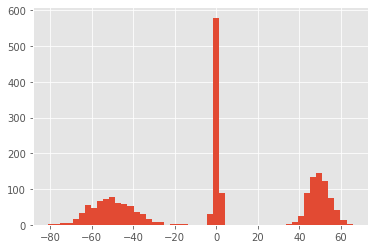

In [48]:
## Adapted from the example given at 
## http://stackoverflow.com/questions/18987697/how-to-model-a-mixture-of-3-normals-in-pymc

# if you touch this seed, the fit breaks :)
# this is *not* a stable fit with these parameters!
np.random.seed(2028)
n = 3
ndata = 2000


## Generate synthetic mixture-of-normals data, 
# with means at -50,0,+50, and std. dev of 5,10,1
v = np.random.randint( 0, n, ndata)
data = ((v==0)*(np.random.normal(50,5,ndata)) + 
        (v==1)*(np.random.normal(-50,10,ndata)) + 
        (v==2)*np.random.normal(0,1,ndata))


## Plot the original data
plt.hist(data, bins=50);  

In [49]:
## A Dirichlet distribution specifies the distribution over categories
## All 1 means that every category is equally likely
dd = mc.Dirichlet('dd', theta=(1,)*n)

## This variable "selects" the category (i.e. the normal distribution)
## to use. The Dirichlet distribution sets the prior over the categories.
category = mc.Categorical('category', 
                          p=dd, size=ndata)

## Now we set our priors the precision and mean of each normal distribution
## Note the use of "size" to generate a **vector** of variables 
# (i.e. one for each category)

## We expect the precision of each normal to be Gamma distributed 
# (this mainly forces it to be positive!)
precs = mc.Gamma('precs', alpha=1, 
                 beta=10, size=n)

## And the means of the normal to be normally distributed, with a precision of 0.001 
# (i.e. std. dev 1000)
means = mc.Normal('means', 0, 1.0/(100*100), size=n)

## These deterministic functions link the means of the observed distribution 
# to the categories
## They just select one of the elements of the mean/precision vector, 
# given the current value of category
## The input variables must be specified in the parameters, so that 
# PyMC knows which variables to pass to it
@mc.deterministic
def mean(category=category, means=means):
    return means[category]

@mc.deterministic
def prec(category=category, precs=precs):
    return precs[category]

In [50]:
## Now we specify the variable we observe -- which is normally distributed, *but*
## we don't know the mean or precision. 
# Instead, we pass the **functions** mean() and pred()
## which will be used at each sampling step.
## We specify the observed values of this node, and tell PyMC these are observed 
## This is all that is needed to specify the model
obs = mc.Normal('obs', mean, prec, 
                value=data, observed = True)

## Now we just bundle all the variables together for PyMC
model = mc.Model({'dd': dd,
              'category': category,
              'precs': precs,
              'means': means,
              'obs': obs})

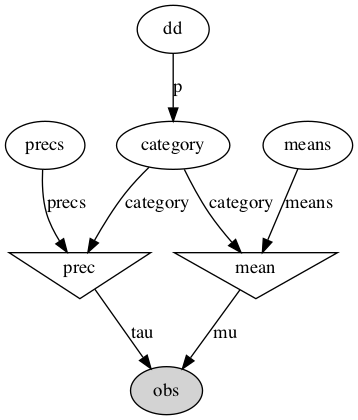

In [51]:
show_dag(model)

In [52]:
mcmc = mc.MCMC(model)

## Now we tell the sampler what method to use
## Metropolis works well, but we must tell PyMC to use a specific
## discrete sampler for the category variable to get good results in a reasonable time
mcmc.use_step_method(mc.AdaptiveMetropolis, 
                     model.means)
mcmc.use_step_method(mc.AdaptiveMetropolis,
                     model.precs)
mcmc.use_step_method(mc.DiscreteMetropolis, 
                     model.category) ## this step is key!
mcmc.use_step_method(mc.AdaptiveMetropolis, 
                     model.dd)

## Run the sampler with 5 different chains
mcmc.sample(iter=150000, burn=1000)

/anaconda3/envs/pymc/lib/python3.6/site-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 150000 of 150000 complete in 84.4 sec

/anaconda3/envs/pymc/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/anaconda3/envs/pymc/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if __name__ == '__main__':
/anaconda3/envs/pymc/lib/python3.6/site-packages/numpy/lib/histograms.py:898: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


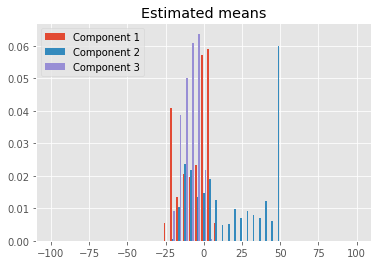

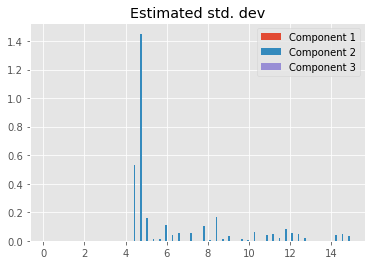

In [53]:
plt.figure()
plt.hist(mcmc.trace('means', chain=None).gettrace()[:], normed=True, bins=np.linspace(-100,100,50))
plt.title("Estimated means")
plt.legend(['Component 1', 'Component 2', 'Component 3'])
plt.figure()
## show the result in terms of std. dev. (i.e sqrt(1.0/precision))
plt.title("Estimated std. dev")
plt.hist(np.sqrt(1.0/mcmc.trace('precs', chain=None).gettrace()[:]), normed=True, 
         bins=np.linspace(0,15,50))
plt.legend(['Component 1', 'Component 2', 'Component 3']);

# Mixture modelling without classification

If all we wanted to do was to estimate the parameters of the mixture (i.e. the PDF), and *not* perform the clustering process that assigns labels to datapoints, then we can write a simpler model. We write a custom stochastic variable representing a mixture-of-Gaussian likelihood function with vector parameters. This then lets us estimate the distribution but does not identify the classes each data point belongs to. This has no discrete parameters and is easier to fit. We can try and do this class labeling post hoc, assigning each observation to the most probable class, but this loses the uncertainty about class membership that we have in the full model above.


In this case we *don't* model the mixture weights and assume they are all equal (this could be done but it makes it harder to sample from). 


In [54]:
## We expect the precision of each normal to be Gamma distributed 
# (this mainly forces it to be positive!)
precs = mc.Gamma('precs', alpha=1, 
                 beta=1, size=n)

means = mc.Normal('means', 0, 1/1e5, size=n)

@mc.stochastic(observed=True)
def mog(means=means, precs=precs, value=data):
    def logp(value, means, precs):           
                      
        ll = [scipy.stats.norm.logpdf(x=value, loc=means[i], 
                                    scale=np.sqrt(1.0/precs[i])) for i in range(len(means))]
        
        # note: we assign data points to the most likely component
        ll = np.sum(np.max(ll, axis=0))
        return ll
    
    def random(means, precs):                
        ix = np.random.choice(ixs)        
        return scipy.stats.norm.rvs(loc=means[ix],
                                    scale=np.sqrt(1.0/precs[ix]), size=value.shape)
    
obs = mog

## Now we just bundle all the variables together for PyMC
model = mc.Model([precs, means, obs])

In [55]:
mcmc = mc.MCMC(model)
mcmc.sample(iter=150000, burn=15000)

 [-----------------100%-----------------] 150000 of 150000 complete in 185.0 sec

Plotting means
Plotting precs


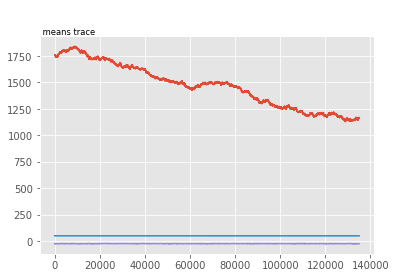

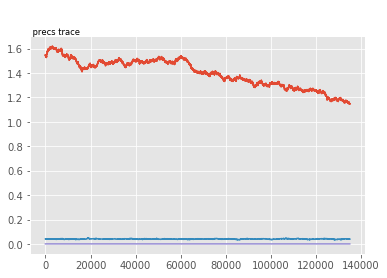

In [56]:
mc.Matplot.trace(mcmc)

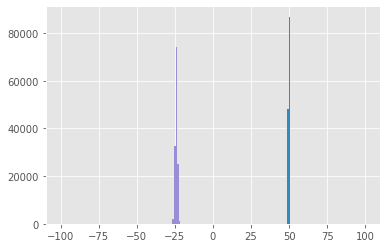

In [57]:
bins = np.linspace(-100,100,200)

plt.hist(mcmc.trace("means")[:,0], bins=bins);
plt.hist(mcmc.trace("means")[:,1], bins=bins);
plt.hist(mcmc.trace("means")[:,2], bins=bins);

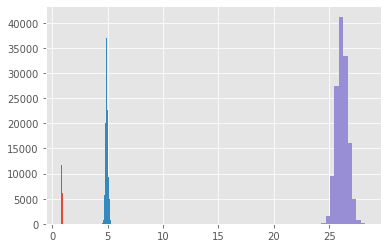

In [59]:
bins = np.linspace(0,20,50)
to_std = lambda x: np.sqrt(1.0/x)
plt.hist(to_std(mcmc.trace("precs")[:,0]))
plt.hist(to_std(mcmc.trace("precs")[:,1]))
plt.hist(to_std(mcmc.trace("precs")[:,2]));

# Imputation in quadratic regression
<a id="imputation"> </a>

In PyMC, variables can be **observed** (fixed) or **unobserved** (random). PyMC cycles through the array of known values for the **observed** variables and updates the rest of the graph.


PyMC implements this using **imputation**, where certain missing values in an observed variable can be inferred (*imputed*) from the rest of the model. This creates new random variables and then infers the missing values. **Masked arrays** are used to implement imputation; these allow arrays to have "blank" values, that PyMC can fill in automatically.

This approach creates one new random variable per missing data item; this can create very large models if you are not careful!




In [60]:
## Example, using very simple quadratic regression model 
import numpy.ma as ma # masked array support

## generate the data for the regression
x = np.sort(np.random.uniform(0, 20, (50,)))
m = 2
c = 15
# Add on some measurement noise, with std. dev. 3.0
epsilon = data = np.random.normal(0, 200, x.shape)
y = m * x * x + c + epsilon

In [61]:
## Now the imputation; we will try and infer missing some missing values of y (we still have the corresponding x)
## mark last three values of y invalid
y_impute = y[:]

n_missing = 6
impute_ixs = np.sort(np.random.randint(0, len(y)-1, size=n_missing))
y_impute[impute_ixs] = 0
y_impute = ma.masked_equal(y_impute,0)
print("Y masked for imputation:", y_impute) # we will see the last three entries with --

Y masked for imputation: [314.67487252694036 28.762343884442195 -132.9300222363724
 32.42002239313529 -74.2558462335792 -219.4845534285443 --
 -307.3425925889724 155.70585255521843 -- 9.258965008062354
 334.5962601375457 -- 31.38240809620158 -135.69769978184118
 189.39461579591784 -8.199952036053787 -- 110.41769382294649
 82.83629793141223 -- 57.97664195478633 490.2596365267436
 380.18265975880206 466.3270188323735 408.6793669451256 116.38339757754362
 -- 432.51741221442296 295.57386537491243 316.57900984301403
 50.81841203275644 399.32630961148345 134.20970800146975
 476.14946769097213 310.76324181090496 264.8349712245391
 358.94768832564966 441.4475629420706 535.3653688329786 650.6887889342563
 239.1021157091543 764.1803075036363 684.0587922536191 266.62283058343826
 876.9073076750643 727.5694710550085 766.5258103672841 644.5102769046218
 791.3303003574911]


In [63]:
# create the model (exactly as before, except we switch "y_impute" for "y")
m_unknown = mc.Normal('m', 0, 0.01)
c_unknown = mc.Normal('c', 0, 0.001)
precision = mc.Gamma('precision', alpha=1, beta=5)
std = mc.Lambda('std_dev', lambda precision=precision: np.sqrt(1.0/precision))
x_obs = mc.Normal("x_obs", 0, 1, 
                  value=x, observed=True)

@mc.deterministic(plot=False)
def line(m=m_unknown, c=c_unknown, x=x_obs):
    return x*x*m+c

y_obs =  mc.Normal('y_obs', mu=line, 
                   tau=precision, value=y_impute, 
                   observed=True)
model = mc.Model([m_unknown, c_unknown, std, 
                  precision, x_obs, y_obs])

In [64]:
# sample from the distribution
mcmc = mc.MCMC(model)
mcmc.sample(iter=100000, burn=5000, thin=10)

 [-----------------100%-----------------] 100000 of 100000 complete in 12.7 sec

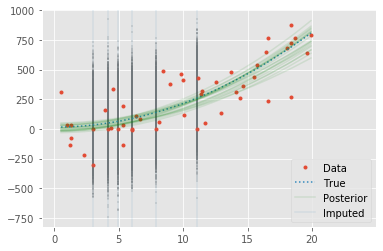

In [65]:
## now we will have three entries in the y_obs trace from this run
y_trace = mcmc.trace('y_obs')[:]
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

## the original data
ax.plot(x, y, '.', label="Data")

ax.plot(x, x*x*m+c, ':', label="True")

m_sample = mcmc.trace("m")[:]
c_sample = mcmc.trace("c")[:]

for i in range(20):
    m_post = np.random.choice(m_sample)
    c_post = np.random.choice(c_sample)
    ax.plot(x, x*x*m_post + c_post, "g", alpha=0.1,
           label="Posterior" if i==0 else None)
    


# samples from posterior predicted for the missing values of y
for i in range(len(impute_ixs)):
        
    ax.axvline(x[impute_ixs[i]], c='C1', alpha=0.1, label="Imputed" if i==0 else None)
    # plot the actual imputed data points
    ax.scatter(np.tile(x[impute_ixs[i]], 
                        (len(y_trace), 1)), 
                        y_trace[:,i], s=2, c='C3', marker='_', 
                        alpha=0.25)
              
    # uncomment to add box plots
    #ax.boxplot([y_trace[:,i]], positions = 
    #           [x[impute_ixs[i]]], widths=2, bootstrap=200,
    #          notch=True, showfliers=False )

ax.set_xlim(-1,25)
ax.set_xticks(np.arange(0,25,5))
ax.set_xticklabels(np.arange(0,25,5))
ax.legend()

/anaconda3/envs/pymc/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


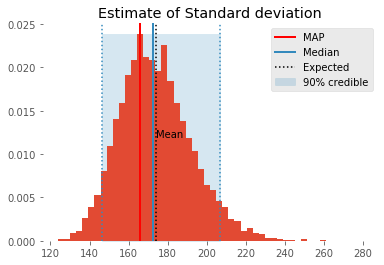

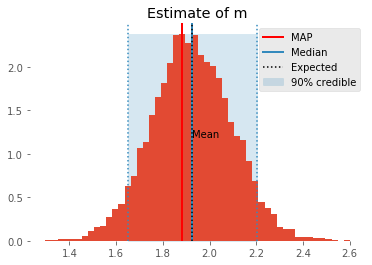

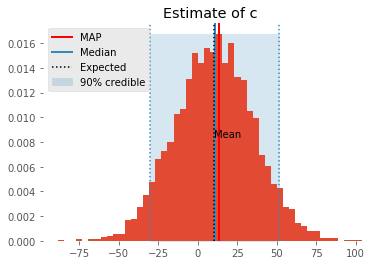

In [66]:
show_trace(mcmc, {"std_dev":"Standard deviation", "m":"m", "c":"c"})

------------